In [52]:
% matplotlib inline

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

matplotlib.style.use('ggplot')

from __future__ import print_function

In [53]:
import psycopg2

/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [51]:
# データセットの読み込み
dataset = pd.read_csv('dataset/kc_house_data.csv')

In [4]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<H2>説明変数の作成</H2>

In [5]:
# 家の広さの合計カラムを作成
dataset['sqft_total'] = dataset['sqft_above'] + dataset['sqft_basement']
dataset.ix[0:9][['id', 'sqft_above', 'sqft_basement', 'sqft_total']]

/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,id,sqft_above,sqft_basement,sqft_total
0,7129300520,1180,0,1180
1,6414100192,2170,400,2570
2,5631500400,770,0,770
3,2487200875,1050,910,1960
4,1954400510,1680,0,1680
5,7237550310,3890,1530,5420
6,1321400060,1715,0,1715
7,2008000270,1060,0,1060
8,2414600126,1050,730,1780
9,3793500160,1890,0,1890


In [6]:
# dateから年と月を抽出する関数
def date_str2year(x):
    # 最初の４文字を取り出せば、年になる
    return int(x[:4])

def date_str2month(x):
    # 5文字から6文字目を取り出せば、月になる
    return int(x[4:6])

In [7]:
# 販売年と販売月のカラムを作成
dataset['date_year'] = dataset['date'].apply(date_str2year)
dataset['date_month'] = dataset['date'].apply(date_str2month)
dataset.ix[0:9][['id','date', 'date_year', 'date_month']]

,id,date,date_year,date_month
0,7129300520,20141013T000000,2014,10
1,6414100192,20141209T000000,2014,12
2,5631500400,20150225T000000,2015,2
3,2487200875,20141209T000000,2014,12
4,1954400510,20150218T000000,2015,2
5,7237550310,20140512T000000,2014,5
6,1321400060,20140627T000000,2014,6
7,2008000270,20150115T000000,2015,1
8,2414600126,20150415T000000,2015,4
9,3793500160,20150312T000000,2015,3


In [8]:
# 販売年から建築年を引いた築年数のカラムを作成
dataset['date'] = pd.to_datetime(dataset['date'])
dataset["house_of_age"] = dataset["date"].dt.year - dataset['yr_built']

In [9]:
#  date_monthを除く
dataset = dataset.drop('date_month',axis=1)

# date_year を除く
dataset = dataset.drop('date_year',axis=1)

In [10]:
# viewのダミー変数を作成
dataset = pd.get_dummies(data=dataset, columns=['view'])

In [11]:
# king street station からの距離（ユークリッド距離）を求める
df_distance_from_station = pd.DataFrame({'distance_from_station' : np.sqrt((((47.59-dataset["lat"]).pow(2) / 0.0111) + ((-122.32-dataset["long"]).pow(2) / 0.0091)))})

In [12]:
# インデックスをキーにdf_distance_from_stationをjoinする
dataset = pd.merge(dataset,df_distance_from_station,right_index=True, left_index=True)

In [13]:
# 近所15件の家に対するリビングの広さの割合
dataset['sqft_living_div_sqft_living15'] = dataset['sqft_living'] / (dataset['sqft_living15'] + 0.001)

In [321]:
# yr_renovatedを1と0で表す（renovatedしていれば1、してなければ0）
# 標準回帰係数を算出した結果、一旦説明変数から削除
# dataset['renovated'] = dataset['yr_renovated'].apply(lambda x: 1 if x > 0  else 0)

In [322]:
# zipcodeのダミー変数を作成
# dataset = pd.get_dummies(data=dataset,columns=['zipcode'])

In [14]:
# basementが存在しているかどうかのダミー変数を作成
dataset['basement_present'] = dataset['sqft_basement'].apply(lambda x:1 if x>0 else 0)

In [15]:
# grade / condition / floorsのダミー変数を作成
category = ['grade','condition','floors']

for i in category:
    dataset = pd.get_dummies(data=dataset,columns=[i])

In [16]:
# 平均価格が高い順にzipcodeを表示
price_by_zipcode = dataset.groupby('zipcode').aggregate({'price':np.mean})
price_by_zipcode.sort_values(by='price',ascending=False).head()

,price
zipcode,
98039,2.160607e+06
98004,1.355927e+06
98040,1.194230e+06
98112,1.095499e+06
98102,9.012583e+05


In [17]:
# 平均価格が高い上位4つのzipcodeのダミー変数を作成
dummies_zipcode = pd.get_dummies(dataset['zipcode'],drop_first=False)
dummies_zipcode = dummies_zipcode.add_prefix("{}_".format('zipcode'))
dummies_zipcode = dummies_zipcode[['zipcode_98039','zipcode_98004','zipcode_98040','zipcode_98112','zipcode_98102']]
dataset.drop('zipcode',axis=1,inplace=True)
dataset = pd.merge(dataset,dummies_zipcode,right_index=True, left_index=True)

In [18]:
dataset.shape

(21613, 54)

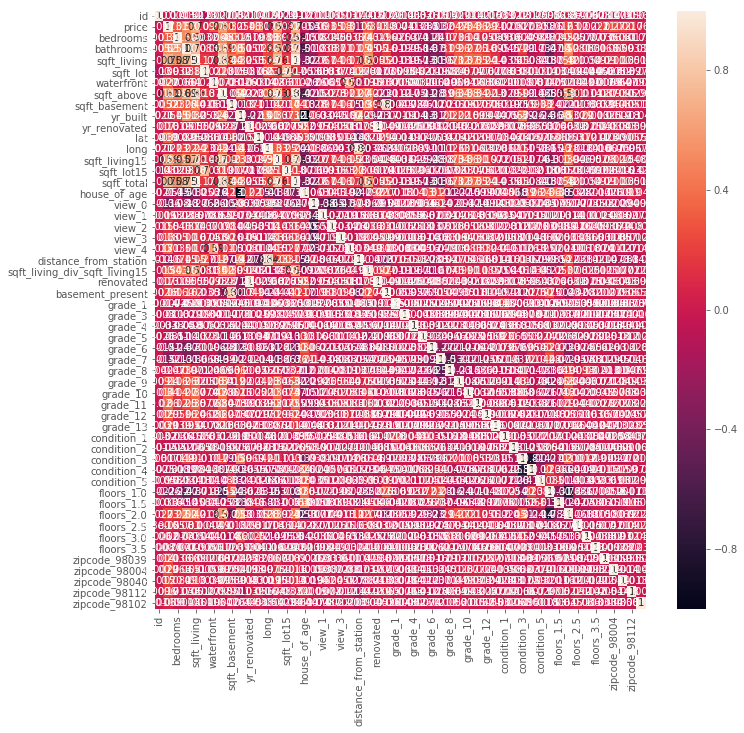

In [328]:
# 各カラムの相関係数を表示
plt.figure(figsize=(11,11))
seaborn.heatmap(dataset.corr(), annot=True)

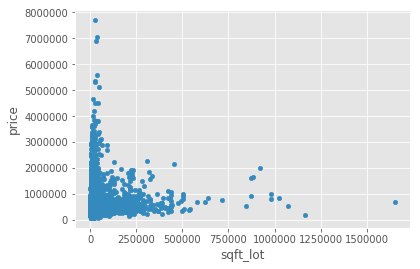

In [19]:
# 説明変数が連続値であるカラムとpriceの可視化
dataset.plot(kind='scatter', x='sqft_lot', y='price')

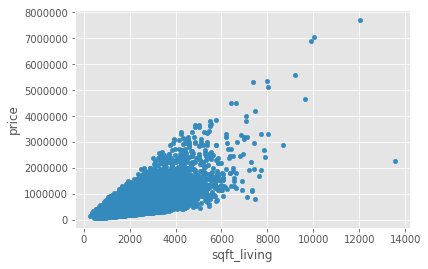

In [20]:
dataset.plot(kind='scatter', x='sqft_living', y='price')

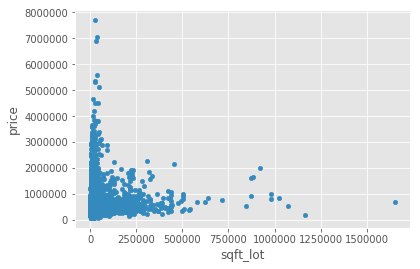

In [21]:
dataset.plot(kind='scatter', x='sqft_lot', y='price')

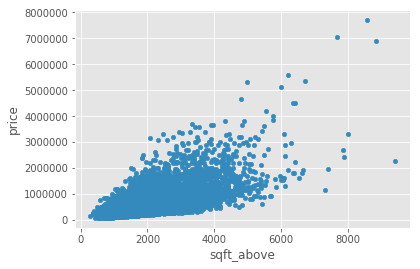

In [22]:
dataset.plot(kind='scatter', x='sqft_above', y='price')

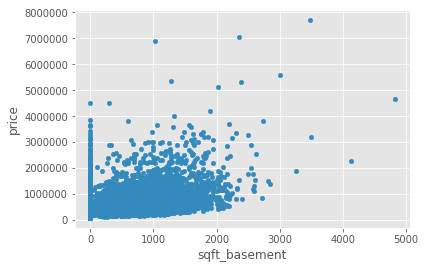

In [23]:
dataset.plot(kind='scatter', x='sqft_basement', y='price')

In [24]:
dataset['area_floor'] = dataset['sqft_living']+dataset['sqft_above']

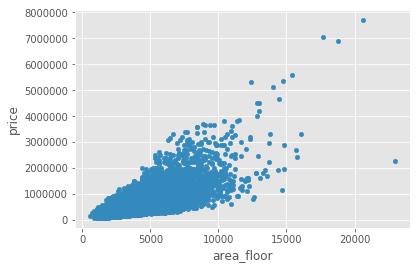

In [25]:
dataset.plot(kind='scatter', x='area_floor', y='price')

In [26]:
# null の確認
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 55 columns):
id                               21613 non-null int64
date                             21613 non-null datetime64[ns]
price                            21613 non-null float64
bedrooms                         21613 non-null int64
bathrooms                        21613 non-null float64
sqft_living                      21613 non-null int64
sqft_lot                         21613 non-null int64
waterfront                       21613 non-null int64
sqft_above                       21613 non-null int64
sqft_basement                    21613 non-null int64
yr_built                         21613 non-null int64
yr_renovated                     21613 non-null int64
lat                              21613 non-null float64
long                             21613 non-null float64
sqft_living15                    21613 non-null int64
sqft_lot15                       21613 non-null int64
sqft_total

<h2>Scikit Learnを用いた予測モデルの構築</h2>

In [27]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [28]:
# 目的変数と説明変数を分ける
target_col = 'price'
exclude_cols = ['price', 'id', 'date']
feature_cols = [col for col in dataset.columns if col not in exclude_cols]

In [29]:
feature_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_total',
 'house_of_age',
 'view_0',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'distance_from_station',
 'sqft_living_div_sqft_living15',
 'basement_present',
 'grade_1',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'zipcode_98039',
 'zipcode_98004',
 'zipcode_98040',
 'zipcode_98112',
 'zipcode_98102',
 'area_floor']

In [30]:
# Numpy配列に変換
y = np.array(dataset[target_col])
X = np.array(dataset[feature_cols])

In [31]:
X.shape

(21613, 52)

In [32]:
y.shape

(21613,)

In [33]:
# 学習データ（70%）と訓練データ（30%）に分ける
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [34]:
# 学習データをさらに分割する
X_train1, X_train2, y_train1, y_train2 = \
 train_test_split(X_train, y_train, test_size=0.3, random_state=1234)

In [35]:
# LinearRgression
lm = LinearRegression()
lm.fit(X_train1, y_train1)
y_pred2 = lm.predict(X_train2)
lm_mse = mean_squared_error(y_train2, y_pred2)

# Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train1,y_train1)
y_pred2_lasso = lasso.predict(X_train2)
lasso_mse = mean_squared_error(y_train2,y_pred2_lasso)

# Ridge
ridge = Ridge()
ridge.fit(X_train1,y_train1)
y_pred2_ridge = ridge.predict(X_train2)
ridge_mse = mean_squared_error(y_train2,y_pred2_ridge)

# RMSE:他のモデルと比較するための相対的な指標
print('LinerRegression RMSE: ', np.sqrt(lm_mse))
print('Lasso RMSE:',np.sqrt(lasso_mse))
print('Ridge RMSE:',np.sqrt(ridge_mse))

LinerRegression RMSE:  170122.46683319795
Lasso RMSE: 170415.17745014303
Ridge RMSE: 169598.41160176802


/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [36]:
# テストデータへの適用
lm = LinearRegression()
lm.fit(X_train1, y_train1)
y_pred = lm.predict(X_test)
lm_mse = mean_squared_error(y_test, y_pred)

print('LinerRegression RMSE: ', np.sqrt(lm_mse))

LinerRegression RMSE:  164956.09109578957


In [343]:
# Lasso回帰のalphaの調整
a = [0.0001,0.0003,0.001,0.005,0.1,0.5,1]

for i in a:
    print('alpha:',i)
    lasso = Lasso(alpha=i)
    lasso.fit(X_train1,y_train1)
    y_pred2_lasso = lasso.predict(X_train2)
    lasso_mse = mean_squared_error(y_train2,y_pred2_lasso)
    print('Lasso RMSE:',np.sqrt(lasso_mse))

alpha: 0.0001


/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso RMSE: 170389.56770999444
alpha: 0.0003
Lasso RMSE: 170389.56688012028
alpha: 0.001
Lasso RMSE: 170389.56397563324
alpha: 0.005
Lasso RMSE: 170389.54738073226
alpha: 0.1
Lasso RMSE: 170389.1543367474
alpha: 0.5
Lasso RMSE: 170387.5222813896
alpha: 1
Lasso RMSE: 170385.36877406813


In [178]:
# テストデータへの適用
lm = LinearRegression()
lm.fit(X_train1, y_train1)
y_pred = lm.predict(X_test)
lm_mse = mean_squared_error(y_test, y_pred)

# Lasso
lasso = Lasso(alpha=0.5)
lasso.fit(X_train1,y_train1)
y_pred_lasso = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test,y_pred_lasso)

# Ridge
ridge = Ridge()
ridge.fit(X_train1,y_train1)
y_pred_ridge = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test,y_pred_ridge)


print('LinerRegression RMSE: ', np.sqrt(lm_mse))
print('Lsso RMSE:',np.sqrt(lasso_mse))
print('Ridge RMSE:',np.sqrt(ridge_mse))

LinerRegression RMSE:  164738.54367776072
Lsso RMSE: 165046.75327463675
Ridge RMSE: 164657.61674226008


/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [179]:
coef_pd = pd.DataFrame(lm.coef_, columns=['coef'], index=feature_cols)
coef_pd

,coef
bedrooms,-1.681332e+04
bathrooms,3.981246e+04
sqft_living,7.591122e+01
sqft_lot,1.638924e-01
waterfront,5.303954e+05
sqft_above,4.642388e+01
sqft_basement,2.948426e+01
yr_built,2.989625e+04
yr_renovated,3.593396e+03
lat,4.506525e+05


<h2>説明変数の目的変数への影響度合い（標準回帰係数）を求める</h2>

In [37]:
from sklearn.preprocessing import StandardScaler

# ダミー変数を定義
norm_exclude_cols = [
'waterfront',
'price',
 'id',
'date',
'view_0',
'view_1',
 'view_2',
 'view_3',
 'view_4',
 'basement_present',
  'grade_1',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
  'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'zipcode_98039',
 'zipcode_98004',
 'zipcode_98040',
 'zipcode_98112',
 'zipcode_98102']

In [38]:
norm_feature_cols = [col for col in dataset.columns if col not in norm_exclude_cols]

In [39]:
target_col = 'price'
exclude_cols = ['price', 'id', 'date']
feature_cols = [col for col in dataset.columns if col not in exclude_cols]
norm_feature_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_total',
 'house_of_age',
 'distance_from_station',
 'sqft_living_div_sqft_living15',
 'area_floor']

In [40]:
# ダミー変数以外を正規化
datas = dataset[norm_feature_cols]
datas_std = StandardScaler().fit_transform(datas)
datas_std = pd.DataFrame(datas_std,columns=datas.columns)
datas_std.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,sqft_total,house_of_age,distance_from_station,sqft_living_div_sqft_living15,area_floor
0,-0.398737,-1.447464,-0.979835,-0.228321,-0.734708,-0.658681,-0.544898,-0.210128,-0.352572,-0.306079,-0.943355,-0.260715,-0.979835,0.533865,-0.808321,-0.537823,-0.891476
1,-0.398737,0.175607,0.533634,-0.189885,0.460841,0.245141,-0.681079,4.746678,1.161568,-0.746341,-0.432686,-0.187868,0.533634,0.670036,-0.600952,1.459796,0.515225
2,-1.473959,-1.447464,-1.426254,-0.123298,-1.229834,-0.658681,-1.293892,-0.210128,1.283537,-0.135655,1.070140,-0.172375,-1.426254,1.316849,-0.237470,-2.402483,-1.376138
3,0.676485,1.149449,-0.130550,-0.244014,-0.891699,1.397515,-0.204446,-0.210128,-0.283288,-1.271816,-0.914174,-0.284522,-0.130550,0.193437,-0.799296,1.211593,-0.507293
4,-0.398737,-0.149007,-0.435422,-0.169653,-0.130895,-0.658681,0.544548,-0.210128,0.409550,1.199335,-0.272190,-0.192849,-0.435422,-0.521461,0.792308,-0.373246,-0.300425


In [41]:
dummy_cols = [
'waterfront',
'view_0',
'view_1',
 'view_2',
 'view_3',
 'view_4',
 'basement_present',
  'grade_1',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
  'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'zipcode_98039',
 'zipcode_98004',
 'zipcode_98040',
 'zipcode_98112',
 'zipcode_98102']
dummy = dataset[dummy_cols]
dummy = pd.DataFrame(dummy,columns=dummy.columns)
dummy.head()

,waterfront,view_0,view_1,view_2,view_3,view_4,basement_present,grade_1,grade_3,grade_4,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98039,zipcode_98004,zipcode_98040,zipcode_98112,zipcode_98102
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [373]:
dataset_norm['renovated'].describe()
# renovatedを削除
dataset.

count    21613.000000
mean         0.042289
std          0.201253
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: renovated, dtype: float64

In [42]:
# 正規化した説明変数とダミー変数の結合
dataset_norm = pd.concat([datas_std,dummy],axis=1)
dataset_norm.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98039,zipcode_98004,zipcode_98040,zipcode_98112,zipcode_98102
0,-0.398737,-1.447464,-0.979835,-0.228321,-0.734708,-0.658681,-0.544898,-0.210128,-0.352572,-0.306079,...,0,0,0,0,0,0,0,0,0,0
1,-0.398737,0.175607,0.533634,-0.189885,0.460841,0.245141,-0.681079,4.746678,1.161568,-0.746341,...,0,1,0,0,0,0,0,0,0,0
2,-1.473959,-1.447464,-1.426254,-0.123298,-1.229834,-0.658681,-1.293892,-0.210128,1.283537,-0.135655,...,0,0,0,0,0,0,0,0,0,0
3,0.676485,1.149449,-0.130550,-0.244014,-0.891699,1.397515,-0.204446,-0.210128,-0.283288,-1.271816,...,0,0,0,0,0,0,0,0,0,0
4,-0.398737,-0.149007,-0.435422,-0.169653,-0.130895,-0.658681,0.544548,-0.210128,0.409550,1.199335,...,0,0,0,0,0,0,0,0,0,0


In [43]:
target_col = 'price'
exclude_cols = ['price', 'id', 'date']
feature_cols_all = [col for col in dataset_norm.columns if col not in exclude_cols]
feature_cols_all

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_total',
 'house_of_age',
 'distance_from_station',
 'sqft_living_div_sqft_living15',
 'area_floor',
 'waterfront',
 'view_0',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'basement_present',
 'grade_1',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'floors_1.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'zipcode_98039',
 'zipcode_98004',
 'zipcode_98040',
 'zipcode_98112',
 'zipcode_98102']

In [44]:
# 正規化されたデータセットをNumpy配列へ変換する
X_norm = np.array(dataset_norm[feature_cols_all])

In [45]:
X_norm_train, X_norm_test, y_train, y_test = \
 train_test_split(X_norm, y, test_size=0.3, random_state=1234)

In [46]:
X_norm_train1, X_norm_train2, y_train1, y_train2 = \
 train_test_split(X_norm_train, y_train, test_size=0.3, random_state=1234)

In [47]:
lm_norm = LinearRegression()
lm_norm.fit(X_norm_train1, y_train1)
y_pred2_norm = lm_norm.predict(X_norm_train2)
lm_mse_norm = mean_squared_error(y_train2, y_pred2_norm)

# RMSE:他のモデルと比較するための相対的な指標
print('LinerRegression RMSE: ', np.sqrt(lm_mse_norm))

LinerRegression RMSE:  170122.46683340432


In [48]:
coef_pd_norm = pd.DataFrame(lm_norm.coef_, columns=['coef'], index=feature_cols_all)
coef_pd_norm

,coef
bedrooms,-1.549042e+04
bathrooms,3.116029e+04
sqft_living,4.635000e+04
sqft_lot,6.572993e+03
sqft_above,3.795045e+04
sqft_basement,2.517834e+04
yr_built,8.793422e+05
yr_renovated,1.113343e+04
lat,6.217546e+04
long,3.386155e+04


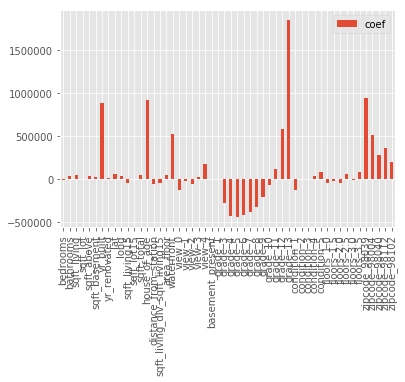

In [49]:
plt.figure(figsize=(10,10))
coef_pd_norm.plot(kind="bar")

In [130]:
# sqrt_lot / yr_renovated / yr_builtの変数を削除
cols = ['yr_renovated','yr_built']

for col in cols:
    dataset = dataset.drop(col,axis=1)

In [131]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98039,zipcode_98004,zipcode_98040,zipcode_98112,zipcode_98102
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,0,1180,0,...,0,0,0,0,0,0,0,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,0,2170,400,...,0,1,0,0,0,0,0,0,0,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,0,770,0,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,0,1050,910,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,0,1680,0,...,0,0,0,0,0,0,0,0,0,0


In [344]:
# 決定木
tree = DecisionTreeRegressor()
tree.fit(X_train1,y_train1)
y_pred2 = tree.predict(X_train2)
tree_mse = mean_squared_error(y_pred2,y_train2)
print("DecisionTree RMSE:",np.sqrt(tree_mse))

DecisionTree RMSE: 190049.6032364084


In [345]:
# 木の深さとRMSEの関係
MAX_DEPTH = 20
depths = range(1,MAX_DEPTH)

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train1,y_train1)
    y_pred2 = tree.predict(X_train2)
    tree_mse = mean_squared_error(y_pred2,y_train2)
    RMSE = np.sqrt(tree_mse)
    print('max_depth={0}:{1}'.format(depth,RMSE))

max_depth=1:314295.13180931786
max_depth=2:280477.79829689517
max_depth=3:241725.35086090924
max_depth=4:221807.13912367116
max_depth=5:195604.7163983522
max_depth=6:182000.22988242173
max_depth=7:169454.49545356748
max_depth=8:184731.49169601282
max_depth=9:186480.35970910251
max_depth=10:174608.43518222732
max_depth=11:195269.81626029973
max_depth=12:195525.76921025728
max_depth=13:197272.97921164776
max_depth=14:190319.5500987582
max_depth=15:190239.87805347203
max_depth=16:184434.0134972879
max_depth=17:195158.1481373634
max_depth=18:187362.75368096156
max_depth=19:182028.74071241956


In [375]:
# 木の深さを調整し（=8）再度精度の確認
tree = DecisionTreeRegressor(max_depth=7)
tree.fit(X_train1,y_train1)
y_pred2 = tree.predict(X_train2)
tree_mse = mean_squared_error(y_pred2,y_train2)
print("DecisionTree RMSE:",np.sqrt(tree_mse))
# seedのパラメーターを探す

DecisionTree RMSE: 171291.16808691435


In [361]:
# ランダムフォレスト
rf = RandomForestRegressor(random_state=1234)
rf.fit(X_train1,y_train1)
y_pred2 = rf.predict(X_train2)
rf_mse = mean_squared_error(y_train2,y_pred2)
print("RandomForest RMSE:",np.sqrt(rf_mse))

RandomForest RMSE: 142622.92811304503


In [362]:
def get_gfs_feature_indices(X, y, features, clf):
    X_train_, X_test_, y_train_, y_test_ = \
        train_test_split(X, y, test_size=0.3, random_state=1234)
    
    #どの特徴量が何列目にあるかを辞書型で保持
    feature_indices = {feature: idx for idx, feature in enumerate(features)}
   
    # 特徴量をユニークにする
    features = set(features)
    
    # 評価（MSE）の初期化
    last_mse = np.inf
    
    #選ばれた特徴量を保存するための空集合を用意
    chosen_features = set()

    while len(chosen_features) < len(features):
        mse_features = []
        
        # 集合は引き算すると差集合
        for feature in (features - chosen_features):
            candidates = chosen_features.union(set([feature]))
            indices = [feature_indices[feature] for feature in candidates]
            clf.fit(X_train_[:, indices], y_train_)
            y_pred = clf.predict(X_test_[:, indices])
            mse = mean_squared_error(y_test_, y_pred)
            mse_features += [(mse, feature)]
        mse, feature = min(mse_features, key= lambda x:x[0])
        
        if mse >= last_mse:
            break
        last_mse = mse
        print('Newly Added Feature: {},\tRMSE Score: {}'.format(feature, np.sqrt(mse)))
        chosen_features.add(feature)
    return [feature_indices[feature] for feature in chosen_features]

In [363]:
selected_feature_index = \
get_gfs_feature_indices(X=X_train, 
                        y=y_train, 
                        features=feature_cols, 
                        clf=RandomForestRegressor(random_state=1234))

Newly Added Feature: sqft_total,	RMSE Score: 270128.50998402364
Newly Added Feature: lat,	RMSE Score: 217191.1785672461
Newly Added Feature: long,	RMSE Score: 178522.1724595027
Newly Added Feature: view_4,	RMSE Score: 166164.21600689733
Newly Added Feature: view_3,	RMSE Score: 156072.38110605555
Newly Added Feature: grade_10,	RMSE Score: 155898.2985977563
Newly Added Feature: floors_2.5,	RMSE Score: 155298.75901343056
Newly Added Feature: sqft_living15,	RMSE Score: 154719.0227611555
Newly Added Feature: waterfront,	RMSE Score: 152305.0561062755


In [364]:
selected_feature_index

[19, 32, 11, 10, 44, 18, 4, 13, 9]

In [365]:
rf = RandomForestRegressor(random_state=1234)
rf.fit(X_train1[:, selected_feature_index], y_train1)
y_pred2 = rf.predict(X_train2[:, selected_feature_index])
rf_mse = mean_squared_error(y_train2, y_pred2)
print('RandomForest RMSE: ', np.sqrt(rf_mse))

RandomForest RMSE:  152305.0561062755


In [366]:
rf = RandomForestRegressor(random_state=1234)

In [367]:
params = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 50]}

In [368]:
#注意: scikit-learnのバージョンが、0.18の場合は、scoring='neg_mean_squared_error'とします
gscv = GridSearchCV(rf, param_grid=params, verbose=1,
                   cv=3, scoring='neg_mean_squared_error')

In [369]:
gscv.fit(X_train1[:, selected_feature_index], y_train1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   20.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=1)

In [370]:
gscv.best_params_

{'max_depth': 50, 'n_estimators': 100}

In [371]:
rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=1234)
rf.fit(X_train1[:, selected_feature_index ], y_train1)
y_pred2 = rf.predict(X_train2[:, selected_feature_index])
rf_mse = mean_squared_error(y_train2, y_pred2)
print('RandomForest RMSE: ', np.sqrt(rf_mse))

RandomForest RMSE:  144225.42630657522
